# Developing a "rotating" simulator

The aim of this notebook is to develop a simulator which allows one to generate mock images of the remnant from any direction. Thus this work moves the problem of rotating the field from the Field part of the infrastructure to the Simulator part. 

In [1]:
import os, sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import imagine as img
# IMAGINE extension package
import imagine_snrs as img_snrs
import shell

In [2]:
dset = img_snrs.datasets.SNR_DA530_I()

In [3]:
measurements = img.observables.Measurements(img_snrs.datasets.SNR_DA530_I(),
                                            img_snrs.datasets.SNR_DA530_Q(),
                                            img_snrs.datasets.SNR_DA530_U(),
                                            img_snrs.datasets.SNR_DA530_FD())

The last dataset contains NaNs which need to be masked before being used in the likelihood. The following cell creates the mask

In [4]:
def create_NaNs_mask(mea):
    masks = img.observables.Masks()
    for k in mea:
        mask = np.isfinite(mea[k].data)
        if np.all(mask):
            continue
        else:
            masks.append(name=k, data=mask)
    return masks

masks = create_NaNs_mask(measurements)

In [5]:
L = 100*u.pc; N = 176
grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                              box=[[-L,L],[-L,L],[-L,L]], 
                              # Grid resolution
                              resolution=[N, N, N])

In [6]:
# Parameters dictionary, including shell parameters
parameters = {'initial_electron_density': 0.01*u.cm**-3,
              'shell_V0':0.0153*u.pc/u.yr, 
              'shell_a': 1.3, 
              'shell_b': 10,
              'elapsed_time': 1300*u.yr,
              'shell_radius': 35*u.pc}

# Creates the IMAGINE Field object
ne_field = img_snrs.fields.SNRThermalElectrons(grid, parameters=parameters)

# Evaluates the field
ne_data = ne_field.get_data()


In [7]:
B_uniform = img_snrs.fields.SNRUniformMagneticField(grid,
                                                    parameters={'B':4*u.microgauss, 
                                                                'beta':0*u.deg, 
                                                                'gamma':90*u.deg})
b_unif = B_uniform.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_unif_list = [b_unif[:,:,:,i] for i in range(3)]

In [8]:
B_helical = img_snrs.fields.SNRSimpleHelicalMagneticField(
    grid, parameters={'B':4*u.microgauss, 'period': 70*u.pc,
                      'alpha':-40*u.deg, 'beta':0*u.deg, 'gamma':20*u.deg})
b_hel = B_helical.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_hel_list = [b_hel[...,i] for i in range(3)]

In [9]:
CR_constant = img_snrs.fields.ConstantCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre': 0.01*u.cm**-3})
ncr_const = CR_constant.get_data()

In [10]:
CR_equip = img_snrs.fields.EquipartitionCosmicRayElectrons(grid, 
                                                           parameters={'cr_energy': 1*u.GeV,
                                                                          'Ecr_Em': 1})
ncr_equip = CR_equip.get_data(dependencies={'magnetic_field': b_hel})

In [11]:
CR_tracking = img_snrs.fields.TrackingCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre_nte': 1})
ncr_track = CR_tracking.get_data(dependencies={'thermal_electron_density': ne_data})

In [12]:
simulator = img_snrs.simulators.SimpleSynchrotron(measurements, 
                                                  distance=11.3*u.kpc, 
                                                  gamma=3., 
                                                  beam_kernel_sd=2.5)
s = simulator

## Extracts the ranges

Uses the distance and the coordinates range to compute the required *physical* x-, y-ranges. 
Uses the size of the box to obtain the z range (integration will happen along z.

In [13]:



coords = s.output_coords[('sync', 1.420967, 'image', 'I')]
nx, ny = coords['shape']

# Extracts ranges from coordinates
lon_range = np.abs(coords['lon_max']-coords['lon_min'])
lat_range = np.abs(coords['lat_max']-coords['lat_min'])

x_range = lon_range.to_value(u.rad) * s.distance
y_range = lat_range.to_value(u.rad) * s.distance

# Uses a diagonal through the box to construct the z range 
# (this aims at using all the available model data)
z_range = 0
for i in range(3):
    z_range += (grid.box[i][1] - grid.box[i][0])**2
z_range = np.sqrt(z_range)    
z_range

<Quantity 346.41016151 pc>

## Constructs the interpolating grid

In [14]:
nz = max((nx, ny))

# nx, ny, nz = grid.resolution 

x_interp = np.linspace(-x_range/2, x_range/2, nx)
y_interp = np.linspace(-y_range/2, y_range/2, ny)
z_interp = np.linspace(-z_range/2, z_range/2, nz)

interp_grid = np.empty((nx, ny, nz, 3)) << x_range.unit

interp_grid[:,:, :, 0], interp_grid[:,:, :, 1], interp_grid[:,:, :, 2] = np.meshgrid(x_interp, 
                                                                                     y_interp,
                                                                                     z_interp,
                                                                                     indexing='ij')
# Saves this for later
depth_grid = interp_grid[:,:, :, 2]

## Rotates the grid

We can use scipy's ready-made rotation matrices

In [15]:
from scipy.spatial.transform import Rotation as R

In [16]:
rot = R.from_euler('zyx', (15,-30,17), degrees=True)

In [17]:
rotated_interp_grid = np.einsum('ji,klmi->klmj', rot.as_matrix(), interp_grid)

## Reference/projection vectors

Later we will need to project the magnetic field parallel or perpendicularly to the plane of the sky -- the original (i.e. unrotated) x-y plane. 

We will create these vectors now, rotate them in the same way as we rotate the coordinate grid and save them for later.

In [18]:
u_LoS_par = np.array([0,0,1])
u_LoS_perp_x = np.array([1,0,0])
u_LoS_perp_y = np.array([0,1,0])

## Visualizing

Text(0, 0.5, 'y')

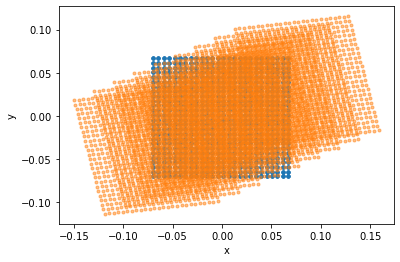

In [19]:
skip = 20
skip_z = 60
plt.scatter(interp_grid[::skip,::skip,::skip_z, 0].ravel(), interp_grid[::skip,::skip,::skip_z, 1].ravel(), marker='.', alpha=0.5)
plt.scatter(rotated_interp_grid[::skip,::skip,::skip_z, 0].ravel(), rotated_interp_grid[::skip,::skip,::skip_z, 1].ravel(), marker='.', alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'z')

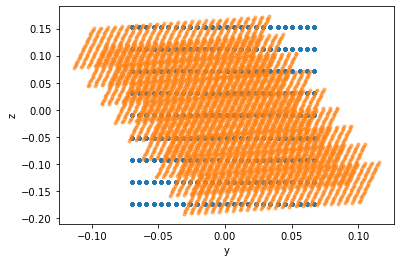

In [20]:
skip = 20
skip_z = 60
plt.scatter(interp_grid[::skip,::skip,::skip_z, 1].ravel(), interp_grid[::skip,::skip,::skip_z, 2].ravel(), marker='.', alpha=0.5)
plt.scatter(rotated_interp_grid[::skip,::skip,::skip_z, 1].ravel(), rotated_interp_grid[::skip,::skip,::skip_z, 2].ravel(), marker='.', alpha=0.5)

plt.xlabel('y')
plt.ylabel('z')

In [21]:
from mpl_toolkits.mplot3d import Axes3D  

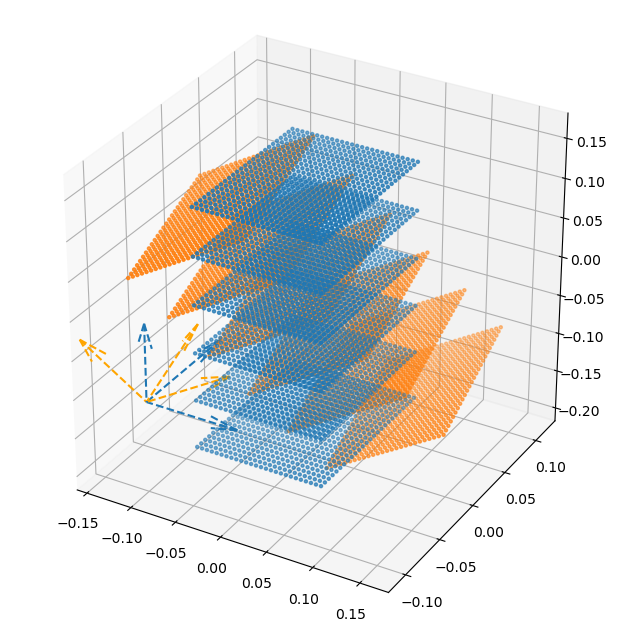

In [22]:
def show_3D(A, skip=20, skip_z=90, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(8,8), dpi=100).add_subplot(111, projection='3d', box_aspect=(1,1,1))
        
    
    ax.scatter(A[::skip,::skip,::skip_z,0].ravel(), 
               A[::skip,::skip,::skip_z,1].ravel(),
               A[::skip,::skip,::skip_z,2].ravel(), marker='.')
    return ax

ax = show_3D(interp_grid)
ax = show_3D(rotated_interp_grid, ax=ax)

ax.quiver(-.1,-.1,-.1, *u_LoS_par,  linestyle='--', length=0.1)
ax.quiver(-.1,-.1,-.1, *u_LoS_perp_x,  linestyle='--', length=0.1)
ax.quiver(-.1,-.1,-.1, *u_LoS_perp_y,  linestyle='--', length=0.1);

ax.quiver(-.1,-.1,-.1, *rot.apply(u_LoS_par), color='orange', linestyle='--', length=0.1)
ax.quiver(-.1,-.1,-.1, *rot.apply(u_LoS_perp_x), color='orange', linestyle='--', length=0.1)
ax.quiver(-.1,-.1,-.1, *rot.apply(u_LoS_perp_y), color='orange', linestyle='--', length=0.1);

In [23]:
rotated_interp_grid.unit

Unit("kpc")

## Checking interpolation

The plan now is, given an appropriate grid, interpolate everything.

Later, one can project the magnetic field (along and perpendicularly to the LoS) and integrate along the `axis=2` (corresponding the LoS or depth). 

The new grid already features a plane-of-sky resolution compatible with the final image.

In [24]:
from scipy.interpolate import RegularGridInterpolator

def interpolate_data(grid_obj, interp_grid, dataset):
    unit = interp_grid.unit
    interpolator = RegularGridInterpolator(points=(grid_obj.x[:,0,0].to_value(unit),
                                                   grid_obj.y[0,:,0].to_value(unit),
                                                   grid_obj.z[0,0,:].to_value(unit)),
                                           values=dataset,
                                           bounds_error=False,
                                           fill_value=np.nan)
    return interpolator(interp_grid.to_value(unit))



In [25]:
test = interpolate_data(grid, rotated_interp_grid, ne_data.value)

To help us to visualize, let us plot some slices, at varying depths.
If the newly interpolated data is being used, different depths correspond to different orange planes in the above figure. If the original data is being used, different depths correspond to different values of $z$.

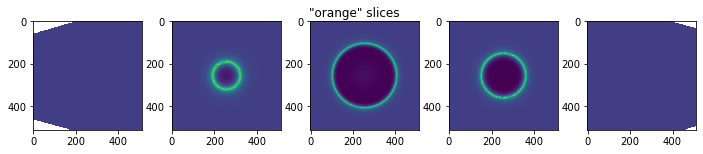

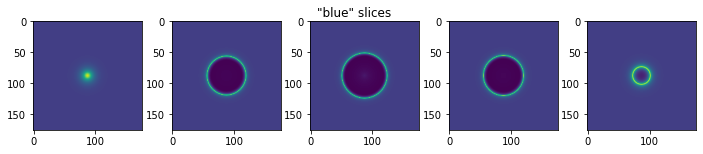

In [26]:
plt.figure(figsize=(12,2))
vmin, vmax = np.nanmin(test), np.nanmax(test)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(test[:,:,150+50*i], vmin=vmin, vmax=vmax)
plt.suptitle('"orange" slices');


plt.figure(figsize=(12,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    idx = (150+51*i) * N//512
    plt.imshow(ne_data[:,:,idx].value, vmin=vmin, vmax=vmax)
plt.suptitle('"blue" slices');

Now the magnetic field

In [27]:
Bx = interpolate_data(grid, rotated_interp_grid, b_unif_list[0])

In [28]:
By = interpolate_data(grid, rotated_interp_grid, b_unif_list[1])

In [29]:
Bz = interpolate_data(grid, rotated_interp_grid, b_unif_list[2])

After this operation, we should have obtained the exact same magnet field, with the exact same orientation and strength, but on a different grid, where the third axis (`axis=2`) corresponds to different LoS depths. To illustrate, let us have two quiver plots, showing the previous field and the new field, but truncating in the middle of the grid.

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:2662: RuntimeWarning: invalid value encountered in greater
  mask = norm > 0


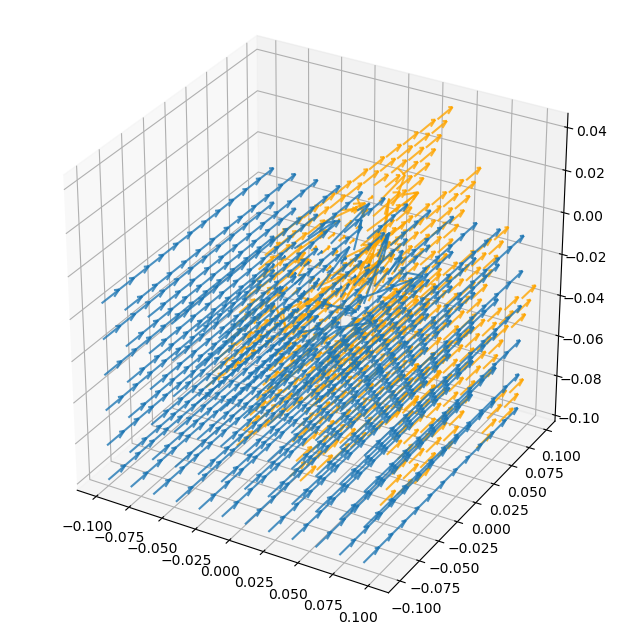

In [30]:
fig =  plt.figure(figsize=(16,8), dpi=100)
ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))



skip=15
# ax = fig.add_subplot(122, projection='3d', box_aspect=(1,1,1))
nzmax = grid.x.shape[2]//2
ax.quiver(grid.x[::skip,::skip,:nzmax:skip].to(rotated_interp_grid.unit), 
          grid.y[::skip,::skip,:nzmax:skip].to(rotated_interp_grid.unit), 
          grid.z[::skip,::skip,:nzmax:skip].to(rotated_interp_grid.unit),
          b_unif_list[0][::skip,::skip,:nzmax:skip],
          b_unif_list[1][::skip,::skip,:nzmax:skip], 
          b_unif_list[2][::skip,::skip,:nzmax:skip], length=0.005, alpha=0.8)

skip = 50
nzmax = rotated_interp_grid.shape[2]//2
ax.quiver(rotated_interp_grid[::skip,::skip,:nzmax:skip,0], 
          rotated_interp_grid[::skip,::skip,:nzmax:skip,1], 
          rotated_interp_grid[::skip,::skip,:nzmax:skip,2],
          Bx[::skip,::skip,:nzmax:skip],
          By[::skip,::skip,:nzmax:skip], 
          Bz[::skip,::skip,:nzmax:skip], length=0.005, color='orange', alpha=0.8)


The blue fills half the box. The orange fills half of a tilted box. So, it is working.


### Further checks

$B^2$ and helicity for overlapping areas

## The new simulator

The new simulator will rely on dummy fields to set the distance and the orientation of the object being looked at.
The steps followed by it are:

1. Generate a rotated grid based on dummy field parameters
2. Interpolate the fields onto the rotated grid
3. Project the vector fields onto the rotated main directions
4. Use previous code (where integration is along z) to compute the observables
5. If needed adjust the format (i.e. 2D-re-interpolate)

If in item 2 one chooses a grid which is at least as dense as the final figure, item 5 is unnecessary. However, if the image is high-res and the grid used by the fields is very low res, step 5 may be necessary.

In [31]:
from scipy.spatial.transform import Rotation as scipy_rotation
from scipy.interpolate import RegularGridInterpolator
import shell.observable as obs


class LoS_integrator(img.simulators.Simulator):
    """
    Simulates the radio images associated with the synchrotron emission signal
    of an object at a large distance.

    It assumes that the distances are sufficient large (relative to the object
    size) to approximate the projections as parallel.  The grid where the
    Fields are constructed is placed at distance `distance`, with the centre

    Parameters
    ----------
    measurements : imagine.observables.Measurements
        Observational data
    distance : astropy.units.Quantity
        The distance to the object in apropriate units (e.g. kpc)
    gamma : float
        The assumed spectral index for the cosmic ray electron distribution
    beam_kernel_sd : float
        If different from `None`, the resulting signal is convolved with
        a gaussian kernel with standard deviation `beam_kernel_sd` (in pixels).
        Otherwise, a pencil beam is assumed.
    interp_method : str
        The interpolation method used by `scipy.interpolate.RegularGridInterpolator`
        to interpolate the resulting images to the same dimensions as the
        images in the `measurements`.
    """
    # Class attributes
    SIMULATED_QUANTITIES = ['sync', 'fd']
    REQUIRED_FIELD_TYPES = ['magnetic_field', 'dummy',
                            'cosmic_ray_electron_density',
                            'thermal_electron_density']
    ALLOWED_GRID_TYPES = ['cartesian']

    def __init__(self, measurements, distance, gamma=1.0, 
                 beam_kernel_sd=None, interp_method='nearest'):
        super().__init__(measurements)
        self.gamma = gamma
        self.Stokes = {}
        self.interp_method = interp_method
        self.distance = distance
        self.beam_kernel_sd = beam_kernel_sd

    def _units(self, key):
        if key[0] == 'sync':
            if key[3] in ('I', 'Q', 'U', 'PI'):
                return u.K
            elif key[3] == 'PA':
                return u.rad
            else:
                raise ValueError
        elif key[0] == 'fd':
            return u.rad/u.m/u.m
        elif key[0] == 'dm':
            return u.pc/u.cm**3
        else:
            raise ValueError


    def _sync_constant(self, gamma):
        from math import sqrt, pi
        from astropy.constants import c, e, m_e
        e = e.esu

        A = sqrt(3) * e**3 / (8*pi*m_e*c**2)
        B = (4*pi*m_e*c**2 / (3*e))**((1-gamma)/2)
        return A*B

    
    def _find_ranges(self, coords):
        """
        Finds the coordinate ranges necessary for constructing the simulated image
        """    
        # Extracts ranges from coordinates
        lon_range = np.abs(coords['lon_max']-coords['lon_min'])
        lat_range = np.abs(coords['lat_max']-coords['lat_min'])

        x_range = lon_range.to_value(u.rad) * self.distance
        y_range = lat_range.to_value(u.rad) * self.distance

        # Uses a diagonal through the box to construct the z range 
        # (this aims at using all the available model data)
        z_range = 0
        for i in range(3):
            z_range += (grid.box[i][1] - grid.box[i][0])**2
        z_range = np.sqrt(z_range)
        
        return x_range, y_range, z_range
    
    
    def _construct_rotation_aux_grid(self, x_range, y_range, z_range, nx, ny, nz):
        """
        Constructs auxiliary quantities associated with rotation
        
        These comprise: an array with rotated coordinates, whose first two
        array axes correspond to the horizontal and vertical directions
        in the plane of the sky, and the third axis corresponds to the 
        depth in the line of sight (LoS), an array containing the LoS depth
        at each point, three unit vectors with the projection directions 
        (parallel and perpendicular to the LoS).
        
        The rotation (Euler) angles are read *directly* from the dummy Field
        parameters.
        
        Parameters
        ----------
        x_range, y_range : astropy.units.Quantity
            *Physical* distances corresponding to the horizontal and 
            vertical sizes of the output in the plane of the sky.
        z_range : astropy.units.Quantity
            *Physical* distance corresponding to the depth along the LoS.
        nx, ny, nz : int
            Number of points used in the grid.
               
        Returns
        -------
        aux_grid : astropy.units.Quantity
            Array with rotated coordinates, whose first two axes correspond to the
            horizontal and vertical directions in the plane of the sky, and
            the third axis corresponds to the depth in the LoS.
        depths_grid : 
            the LoS depth at each point.
        u_LoS_par : numpy.ndarray 
            Unit vector parallel to the LoS
        u_LoS_perp_x, u_LoS_perp_y : numpy.ndarray
            Unit vectors perpendicular to the LoS and to each other            
        """
        x_aux = np.linspace(-x_range/2, x_range/2, nx)
        y_aux = np.linspace(-y_range/2, y_range/2, ny)
        z_aux = np.linspace(-z_range/2, z_range/2, nz)

        aux_grid = np.empty((nx, ny, nz, 3)) << x_range.unit

        aux_grid[:,:, :, 0], aux_grid[:,:, :, 1], aux_grid[:,:, :, 2] = np.meshgrid(x_aux, y_aux,
                                                                                    z_aux, indexing='ij')
        # Saves the LoS depth for the integration later
        depths_grid = aux_grid[:,:, :, 2]
        
        # Rotates the coordinates grid
        params = self.fields['dummy']
        rot = scipy_rotation.from_euler('zyx', (params['gamma'].to_value(u.rad),
                                                params['beta'].to_value(u.rad),
                                                params['alpha'].to_value(u.rad)))
        # Matrix product of each value in the grid
        aux_grid = np.einsum('ji,klmi->klmj', rot.as_matrix(), aux_grid)
        
        # Constructs projection versors
        u_LoS_par = rot.apply(np.array([0,0,1]))
        u_LoS_perp_x = rot.apply(np.array([1,0,0]))
        u_LoS_perp_y = rot.apply(np.array([0,1,0]))
        
        return aux_grid, depths_grid, u_LoS_par, u_LoS_perp_x, u_LoS_perp_y
        
    def _interpolate_data(self, aux_grid, data, fill_value=0.0):
        """
        Interpolates data on a new grid
        
        Paramters
        ---------
        aux_grid : astropy.units.Quantity
            Auxiliary (L,M,N,3)-array with the coordinate grid to which one wants 
            to interpolate the data.
        data : astropy.units.Quantity
            Array containing the dataset to be interpolated. It must be defined
            on the grid available at `self.grid`.
        
        Returns
        -------
        interpolated_data
            The interpolated `data` onto the `aux_grid` coordinates
        
        """
        unit = aux_grid.unit    
        interpolator = RegularGridInterpolator(points=(self.grid.x[:,0,0].to_value(unit),
                                                       self.grid.y[0,:,0].to_value(unit),
                                                       self.grid.z[0,0,:].to_value(unit)),
                                               values=data.value,
                                               bounds_error=False,
                                               fill_value=fill_value)
        interpolated_data = interpolator(aux_grid.to_value(unit)) << data.unit
        
        return interpolated_data
        
    def _get_projected_interpolated_B(self, aux_grid, B, v_par, v_perp_x, v_perp_y):
        B_interp = np.empty(aux_grid.shape) << B.unit
        for i in range(3):
            B_interp[:,:,:,i] = self._interpolate_data(aux_grid, B[:,:,:,i])

        # Projects onto LoS
        Bpara = np.einsum('ijkl,l->ijk', B_interp, v_par, optimize=True)
        # Project on plane of the sky
        Bperp_x = np.einsum('ijkl,l->ijk', B_interp, v_perp_x, optimize=True)
        Bperp_y = np.einsum('ijkl,l->ijk', B_interp, v_perp_y, optimize=True)

        return Bperp_x, Bperp_y, Bpara
            

    def simulate(self, key, coords_dict, realization_id, output_units):
        obs_name, freq, _, flag = key

        if obs_name == 'fd':
            flag = 'fd'
            # This makes the 'fd' (which usually do not have a flag)
            # behave similarly to 'sync'
            
            
        if flag not in self.Stokes:
            # Stores the distance for later
            self.distance = self.fields['dummy']['distance']
            
            x_range, y_range, z_range = self._find_ranges(coords_dict)
            
            aux_grid, depth, v_par, v_perp_x, v_perp_y = self._construct_rotation_aux_grid(
                x_range, y_range, z_range, *grid.resolution)
            
            # Prepares interpolated quantities
            ne = self._interpolate_data(aux_grid, self.fields['thermal_electron_density'])
            ncr = self._interpolate_data(aux_grid,
                                         self.fields['cosmic_ray_electron_density'][:,:,:,0])
            
            Bperp_x, Bperp_y, B_para = self._get_projected_interpolated_B(aux_grid, 
                                                                          self.fields['magnetic_field'],
                                                                          v_par, v_perp_x, v_perp_y)
            
            # Computes Faraday depth, if this was requested
            if ('fd' in [k[0] for k in self.observables]):
                
                self.Stokes['fd'] = obs.compute_fd(depth, B_para, ne,
                                                   beam_kernel_sd=self.beam_kernel_sd)
                
            # Computes synchrotron (I,Q,U), if this was requested
            if ('sync' in [k[0] for k in self.observables]):
                wavelength = (freq*u.GHz).to(u.cm, equivalencies=u.spectral())

                I, U, Q = obs.compute_stokes_parameters(depth, wavelength,
                                                        Bperp_x, Bperp_y, B_para,
                                                        ne, ncr, gamma=self.gamma,
                                                        beam_kernel_sd=self.beam_kernel_sd)
                self.Stokes['I'] = I
                self.Stokes['Q'] = Q
                self.Stokes['U'] = U
        
        out_data = self.Stokes.pop(flag)
        out_data_units = out_data.unit
        
        # Now, we need to interpolate to the original image resolution
        # First, store the available coordinates
        # (NB there was another round of interpolation before, which 
        # placed the data precisely within the coordinates of the image, 
        # but perhaps in the wrong resolution)
        x_range, y_range, z_range = self._find_ranges(coords_dict)
        x = np.linspace(-x_range/2, x_range/2, self.grid.resolution[0])
        y = np.linspace(-y_range/2, y_range/2, self.grid.resolution[1])
        
        # Setup the interpolator
        interpolator = RegularGridInterpolator(points=(x.to_value(u.kpc), y.to_value(u.kpc)),
                                               values=out_data.value,
                                               bounds_error=False,
                                               fill_value=0,
                                               method=self.interp_method)

        # Now we convert the original Galactic coordinates into x and y
        # under the assumption that the centres of the images coincide
        coords = self.output_coords[key]
        nx, ny = coords['shape']

        lon_range = np.abs(coords['lon_max'] - coords['lon_min'])
        lat_range = np.abs(coords['lat_max'] - coords['lat_min'])

        x_range = lon_range.to_value(u.rad) * self.distance
        y_range = lat_range.to_value(u.rad) * self.distance

        x_target = np.linspace(-x_range/2, x_range/2, nx)
        y_target = np.linspace(-y_range/2, y_range/2, ny)
        x_target, y_target = np.meshgrid(x_target, y_target)

        interp_points = np.array([x_target, y_target]).T

        result = interpolator(interp_points) * out_data_units

        # Adjusts the units
        if obs_name == 'sync':
            sync_constant = self._sync_constant(self.gamma)

            # The following is a hack to deal with a missing equivalency in
            # astropy units
            B_unit_adj = (1./u.gauss) * (u.Fr/u.cm**2)  # This should be 1
            sync_constant *= B_unit_adj**((self.gamma+1)/2)

            result = result * sync_constant

            # The result, so far, corresponds to a surface density of luminosity,
            # i.e. the energy per area in the remnant, but we want flux density,
            # the energy per unit area at the detector, thus
            result *= (x_range/nx)*(y_range/ny)/(self.distance)**2

            # Finally, we want the surface brightness (the flux density per
            # detector solid angle), i.e. we nee to account for the (pencil) beam
            beam_size = (lon_range/nx)*(lat_range/ny)
            result /= beam_size

            # Converts into brightness temperature
            result = result.to(u.K,
                              equivalencies=u.brightness_temperature(freq<<u.GHz))

        return result.ravel()



This implementation requires defining dummy field that is used for adjusting (and constraining) the settings of the simulator.

In [32]:
class LoSintegratorSettings(img.fields.DummyField):
    NAME = 'LoS_integrator_settings'
    FIELD_CHECKLIST = {'alpha': None,
                       'beta': None,
                       'gamma': None,
                       'distance': None}
    SIMULATOR_CONTROLLIST = {}

    
dummy_field = LoSintegratorSettings(parameters={'alpha': 0*u.rad,
                                               'beta': 0*u.rad,
                                               'gamma': 0*u.rad,
                                               'distance': 11.3*u.kpc})    

And the associated `FieldFactory` is

In [33]:
priors = {'alpha': img.priors.FlatPrior(-180, 180, u.deg, wrapped=True), 
          'beta': img.priors.FlatPrior(-90, 90, u.deg), 
          'gamma': img.priors.FlatPrior(-180, 180, u.deg, wrapped=True)}
          

dummy_factory = img.fields.FieldFactory(dummy_field, 
                                        active_parameters=('alpha','beta','gamma'),
                                        priors=priors, grid=grid)


### Testing the new class

I will first check whether each individual method is fine

In [34]:
simulator = LoS_integrator(measurements, distance=11.3*u.kpc,
                           gamma=3., beam_kernel_sd=2.5)

In [35]:
x_range, y_range, z_range = simulator._find_ranges(measurements[('sync', 1.420967, 'image', 'I')].coords)
x_range, y_range, z_range

(<Quantity 0.13997297 kpc>,
 <Quantity 0.13997297 kpc>,
 <Quantity 346.41016151 pc>)

For further tests, the simulator must know the available fields (see `__call__` method in the source code).

In [36]:
fields_list = [dummy_field, ne_field, CR_constant, B_uniform]

def read_fields(simulator, fields_list):
    simulator.register_ensemble_size(fields_list)
    # Prepares all fields
    simulator.prepare_fields(fields_list,0)

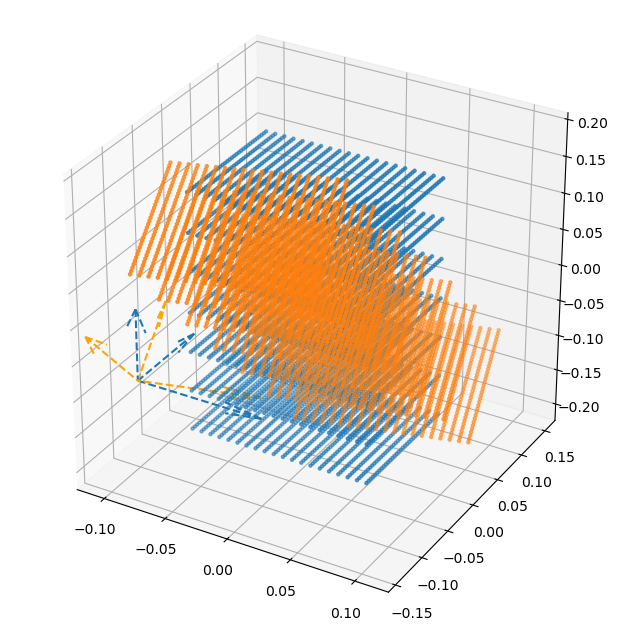

In [37]:
dummy_field = LoSintegratorSettings(parameters={'alpha': 0*u.deg,
                                               'beta': 0*u.rad,
                                               'gamma': 0*u.rad,
                                               'distance': 11.3*u.kpc})                                                                                                          
fields_list = [dummy_field, ne_field, CR_constant, B_uniform]
read_fields(simulator, fields_list)

aux_grid, depths_grid, u_LoS_par, u_LoS_perp_x, u_LoS_perp_y = simulator._construct_rotation_aux_grid(x_range, y_range, z_range,
                                                                                                      nx=20, ny=35, nz=20)
ax = show_3D(aux_grid, skip=1, skip_z=3)

ax.quiver(-.1,-.1,-.1, *u_LoS_par,  linestyle='--', length=0.1)
ax.quiver(-.1,-.1,-.1, *u_LoS_perp_x,  linestyle='--', length=0.1)
ax.quiver(-.1,-.1,-.1, *u_LoS_perp_y,  linestyle='--', length=0.1);

dummy_field = LoSintegratorSettings(parameters={'alpha': 30*u.deg,
                                               'beta': -10*u.deg,
                                               'gamma': 10*u.deg,
                                               'distance': 11.3*u.kpc})                                                                                                          
fields_list = [dummy_field, ne_field, CR_constant, B_uniform]
read_fields(simulator, fields_list)

aux_grid, depths_grid, u_LoS_par, u_LoS_perp_x, u_LoS_perp_y = simulator._construct_rotation_aux_grid(x_range, y_range, z_range,
                                                                                                      nx=20, ny=35, nz=20)
ax = show_3D(aux_grid, skip=1, skip_z=3, ax=ax)

ax.quiver(-.1,-.1,-.1, *u_LoS_par,  linestyle='--', length=0.1, color='orange')
ax.quiver(-.1,-.1,-.1, *u_LoS_perp_x,  linestyle='--', length=0.1, color='orange')
ax.quiver(-.1,-.1,-.1, *u_LoS_perp_y,  linestyle='--', length=0.1, color='orange');

In [38]:
ne_data = simulator._interpolate_data(aux_grid, simulator.fields['thermal_electron_density'],
                            fill_value=np.nan)

In [39]:
ne_data.shape, aux_grid.shape, grid.shape

((20, 35, 20), (20, 35, 20, 3), array([176, 176, 176]))

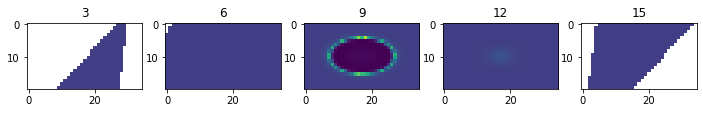

In [40]:
plt.figure(figsize=(12,2))

increment = aux_grid.shape[2]//6

for i, idx in enumerate(range(increment, increment*6, increment)):
    plt.subplot(1,5,i+1)
    plt.title(idx)
    plt.imshow(ne_data[:,:,idx].value, vmin=vmin, vmax=vmax)

In [41]:
Bperp_x, Bperp_y, Bpara = simulator._get_projected_interpolated_B(
    aux_grid, simulator.fields['magnetic_field'], u_LoS_par, u_LoS_perp_x, u_LoS_perp_y)

In [42]:
ok = (Bperp_y == 0) * (Bperp_x == 0)
Bperp_y[~ok]/Bperp_x[~ok]

<Quantity [13.37797188, 13.37797325, 13.37797667, ..., 13.37797667,
           13.37797325, 13.37797188]>

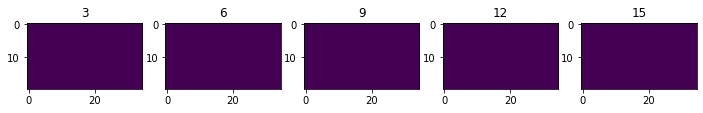

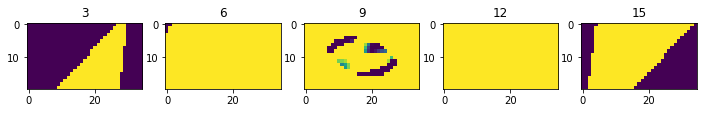

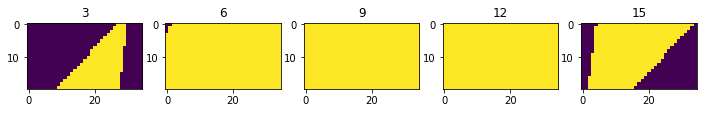

In [43]:
plt.figure(figsize=(12,2))
for i, idx in enumerate(range(increment, increment*6, increment)):
    plt.subplot(1,5,i+1)
    plt.title(idx)
    plt.imshow(Bpara[:,:,idx].value, vmin=vmin, vmax=vmax)

plt.figure(figsize=(12,2))
for i, idx in enumerate(range(increment, increment*6, increment)):
    plt.subplot(1,5,i+1)
    plt.title(idx)
    plt.imshow(Bperp_x[:,:,idx].value, vmin=vmin, vmax=vmax)

plt.figure(figsize=(12,2))
for i, idx in enumerate(range(increment, increment*6, increment)):
    plt.subplot(1,5,i+1)
    plt.title(idx)
    plt.imshow(Bperp_y[:,:,idx].value, vmin=vmin, vmax=vmax)

The methods seem to be ok. Now it is time to *integrate everything*!

In [44]:
simulator = LoS_integrator(measurements, distance=11.3*u.kpc,
                           gamma=3., beam_kernel_sd=2.5)

In [45]:
dummy_field = LoSintegratorSettings(parameters={'alpha': 0*u.deg,
                                               'beta': 0*u.deg,
                                               'gamma': 0*u.deg,
                                               'distance': 11.3*u.kpc})                                                                                                          

fields_list = [dummy_field, ne_field, CR_constant, B_uniform]

simulations = simulator(fields_list)

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


It runs. But how does it look like?

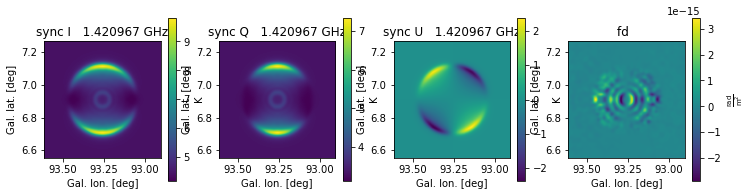

In [46]:
plt.figure(figsize=(12,3))
simulations.show()

Now let us see if we can rotate this pattern (using the dummy field to change the settings)

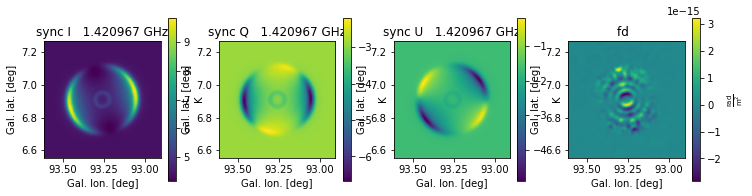

In [47]:
dummy_field = LoSintegratorSettings(parameters={'alpha': 0*u.deg,
                                               'beta': 0*u.deg,
                                               'gamma': 75*u.deg,
                                               'distance': 11.3*u.kpc})                                                                                                          
fields_list = [dummy_field, ne_field, CR_constant, B_uniform]

simulations = simulator(fields_list)

plt.figure(figsize=(12,3))
simulations.show()

Let us rotate again, but around other axes

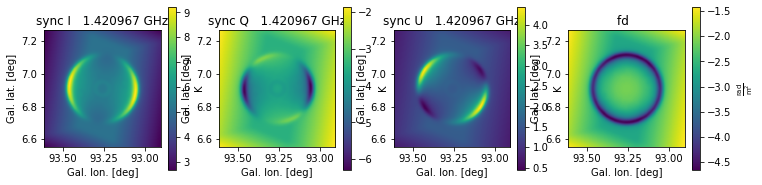

In [48]:
dummy_field = LoSintegratorSettings(parameters={'alpha': 30*u.deg,
                                               'beta': 50*u.deg,
                                               'gamma': 75*u.deg,
                                               'distance': 11.3*u.kpc})                                                                                                          
fields_list = [dummy_field, ne_field, CR_constant, B_uniform]

simulations = simulator(fields_list)

plt.figure(figsize=(12,3))
simulations.show()

We can see some artifacts in the images, which are consequences of the lack of overlap of our finite initial box with part of the rotated grid. To avoid these, we will need to have slightly larger boxes (which are effectively cropped to the image size, just before the interpolation step).

The distance can now also be used in the fitting. Below, we see the effect of decreasing the distance.

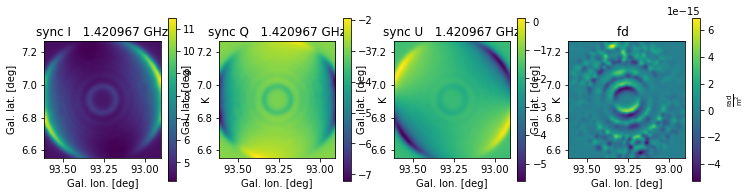

In [49]:
dummy_field = LoSintegratorSettings(parameters={'alpha': 0*u.deg,
                                               'beta': 0*u.deg,
                                               'gamma': 75*u.deg,
                                               'distance': 6.3*u.kpc})                                                                                                          
fields_list = [dummy_field, ne_field, CR_constant, B_uniform]

simulations = simulator(fields_list)
plt.figure(figsize=(12,3))
simulations.show()